<a href="https://colab.research.google.com/github/ayman86/Photo_Quality_Classification/blob/main/SimpelNet_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import os
import random
import matplotlib.pylab as plt
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow
import tensorflow.keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from keras.applications.efficientnet_v2 import EfficientNetV2S
from keras.applications.efficientnet import preprocess_input

In [2]:
def proc_image_dir(Images_Path):
    
    image_classes = sorted([dirname for dirname in os.listdir(Images_Path)
                      if os.path.isdir(os.path.join(Images_Path, dirname))])
    # and not dirname.startswith(".") and not dirname.startswith("mblur")])
    #image_classes.append('mblur')
    
    print(image_classes)
    
    x = [] # images as arrays
    y = [] # labels Infiltration or Not_infiltration
    WIDTH = 256
    HEIGHT = 256
  
    print("Adding Images: ",end="")
    i = 0
    for image_class in image_classes:
        print("Processing ", image_class)
        items = glob(os.path.join(Images_Path, image_class,"*"))
        for item in items:
            if item.lower().endswith(".jpg") or item.lower().endswith(".bmp"):
                # Read and resize image
                full_size_image = cv2.imread(item)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                out = [0] * len(image_classes)
                out[i] = 1
                y.append(out)
        i+=1

    print("")
    return x,y,image_classes

def horizontal_motion_blur(img, blur_factor):
    

    kernel_size = blur_factor
    kernel_h = np.zeros((kernel_size, kernel_size))
    kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size) 
    kernel_h /= kernel_size 

    # Apply the horizontal kernel. 
    horizontal_mb = cv2.filter2D(img, -1, kernel_h) 
    
    return horizontal_mb

In [4]:
# ./input/
PATH = os.path.abspath(os.path.join('.', 'databaserelease2'))

# ./input/sample/images/
SOURCE_IMAGES = '/content/drive/MyDrive/Datasets - Copy/First Dataset'#os.path.join(PATH, "sample", "images")
x2,y2,image_classes = proc_image_dir(SOURCE_IMAGES)


['bad_lighting', 'fastfading', 'gblur', 'jp2k', 'jpeg', 'refimgs']
Adding Images: Processing  bad_lighting
Processing  fastfading
Processing  gblur
Processing  jp2k
Processing  jpeg
Processing  refimgs



In [6]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_valtest, y_train, y_valtest = train_test_split(x2,y2, test_size=0.20, random_state=1, stratify=y2)

# Second split the 40% into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)

print(np.array(X_train).shape)
print(np.array(X_val).shape)
print(np.array(X_test).shape)

(796, 256, 256, 3)
(100, 256, 256, 3)
(100, 256, 256, 3)


In [7]:
num_classes=6

K.image_data_format()

img_width, img_height = 256, 256
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
epochs = 100
batch_size = 16

In [9]:
from tensorflow.keras.layers import Input, Dense, Activation,Flatten,Conv2D,MaxPool2D,Dropout
from tensorflow.keras.models import Model

input_shape = (256,256,3)

#creat the network
#input layer
img_input = Input(shape=input_shape,name = 'img_input')

#conv_layer
l1 = Conv2D(32,(3,3),padding='same',activation='relu',name='l1')(img_input)
l1 = Conv2D(64,(3,3),padding='same',activation='relu',name='l2')(l1)
l1 = MaxPool2D((2,2),strides=(2,2),name='l3')(l1)
l1 = Dropout(0.2)(l1)

l1 = Conv2D(64,(3,3),padding='same',activation='relu',name='l4')(l1)
l1 = MaxPool2D((2,2),strides=(2,2),name='l5')(l1)
l1 = Dropout(0.2)(l1)

l1 = Conv2D(128,(3,3),padding='same',activation='relu',name='l6')(l1)
l1 = MaxPool2D((2,2),strides=(2,2),name='l7')(l1)
l1 = Dropout(0.3)(l1)

l1 = Conv2D(128,(3,3),padding='same',activation='relu',name='l8')(l1)
l1 = MaxPool2D((2,2),strides=(2,2),name='l9')(l1)
l1 = Dropout(0.3)(l1)

l1 = Conv2D(256,(3,3),padding='same',activation='relu',name='l10')(l1)
l1 = MaxPool2D((2,2),strides=(2,2),name='l11')(l1)
l1 = Dropout(0.4)(l1)

l1 = Conv2D(256,(3,3),padding='same',activation='relu',name='l12')(l1)
l1 = MaxPool2D((2,2),strides=(2,2),name='l13')(l1)
l1 = Dropout(0.4)(l1)

l1 = Flatten(name='fc1')(l1)
l1 = Dense(64,name='l14')(l1)
l1 = Dropout(0.5)(l1)

l1 = Dense(6,activation='sigmoid',name='predictions')(l1)

model = Model(inputs=img_input,outputs=l1,name='Binary_classification')
model.summary()




Model: "Binary_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 256, 256, 3)]     0         
                                                                 
 l1 (Conv2D)                 (None, 256, 256, 32)      896       
                                                                 
 l2 (Conv2D)                 (None, 256, 256, 64)      18496     
                                                                 
 l3 (MaxPooling2D)           (None, 128, 128, 64)      0         
                                                                 
 dropout_7 (Dropout)         (None, 128, 128, 64)      0         
                                                                 
 l4 (Conv2D)                 (None, 128, 128, 64)      36928     
                                                                 
 l5 (MaxPooling2D)           (None, 64, 64, 6

In [ ]:
model.compile(
	loss='binary_crossentropy',
	optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
	metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.01,
                                   zoom_range=[0.9, 1.25],
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='reflect')
valtest_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size)
validation_generator = valtest_datagen.flow(np.array(X_val), y_val, batch_size=batch_size)
test_generator = valtest_datagen.flow(np.array(X_test), y_test, batch_size=batch_size)

history = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)), epochs=50)


Epoch 1/50
25/25 [==============================] - 58s 780ms/step - loss: 0.4524 - acc: 0.3857 - val_loss: 0.3252 - val_acc: 0.5200
Epoch 2/50
25/25 [==============================] - 14s 562ms/step - loss: 0.3102 - acc: 0.5251 - val_loss: 0.2569 - val_acc: 0.5900
Epoch 3/50
25/25 [==============================] - 14s 568ms/step - loss: 0.2710 - acc: 0.5804 - val_loss: 0.2409 - val_acc: 0.6400
Epoch 4/50
25/25 [==============================] - 15s 584ms/step - loss: 0.2741 - acc: 0.5942 - val_loss: 0.2597 - val_acc: 0.6100
Epoch 5/50
25/25 [==============================] - 15s 584ms/step - loss: 0.2445 - acc: 0.6219 - val_loss: 0.2303 - val_acc: 0.6600
Epoch 6/50
25/25 [==============================] - 15s 590ms/step - loss: 0.2289 - acc: 0.6394 - val_loss: 0.2206 - val_acc: 0.6700
Epoch 7/50
25/25 [==============================] - 15s 584ms/step - loss: 0.2160 - acc: 0.6508 - val_loss: 0.2000 - val_acc: 0.6900
Epoch 8/50
25/25 [==============================] - 15s 582ms/step - 

In [ ]:
model.save_weights('/content/drive/MyDrive/Datasets - Copy/8020weights.h5')


In [ ]:
model.load_weights('/content/drive/MyDrive/Datasets - Copy/8020weights.h5')


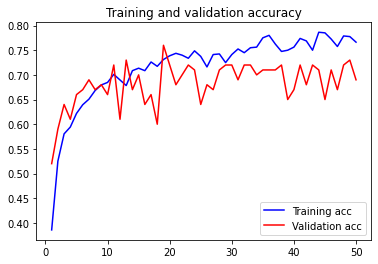

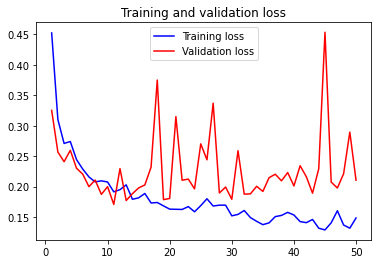

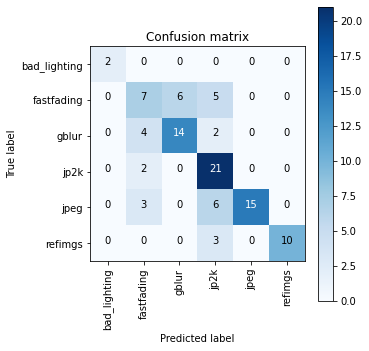

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("/content/drive/MyDrive/Datasets - Copy/trvlAcc.png")
plt.show()

plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/Datasets - Copy/trvlLoss.png")
plt.show()

import sklearn
import itertools
from sklearn.metrics import confusion_matrix
dict_characters = {0: 'Clear', 1: 'Blurry'}
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("/content/drive/MyDrive/Datasets - Copy/cm-"+title+".png")
    plt.show()

    
a=np.array(X_test)
b=np.array(y_test)
Y_pred = model.predict(a)


Y_pred_classes = np.argmax(Y_pred,axis=1)
confusion_mtx = confusion_matrix(np.argmax(b,axis=1), Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(image_classes))

In [ ]:
sklearn.metrics.accuracy_score(Y_pred_classes,np.argmax(b,axis=1))


0.69

In [ ]:
confusion_mtx


array([[ 2,  0,  0,  0,  0,  0],
       [ 0,  7,  6,  5,  0,  0],
       [ 0,  4, 14,  2,  0,  0],
       [ 0,  2,  0, 21,  0,  0],
       [ 0,  3,  0,  6, 15,  0],
       [ 0,  0,  0,  3,  0, 10]])

In [ ]:
class_totals = [sum(i) for i in confusion_mtx]
class_totals

[2, 18, 20, 23, 24, 13]

In [ ]:
class_correct_pred = [confusion_mtx[i][i] for i in range(6)]
class_correct_pred

[2, 7, 14, 21, 15, 10]

In [ ]:
accuracies = [class_correct_pred[i]/class_totals[i] for i in range(6)]
accuracies

[1.0, 0.3888888888888889, 0.7, 0.9130434782608695, 0.625, 0.7692307692307693]

In [ ]:
class_totals = [sum(i) for i in confusion_mtx]
class_totals

tp = [confusion_mtx[i][i] for i in range(6)]
tp

sensetivity = [tp[i]/class_totals[i] for i in range(6)]
sensetivity

[1.0, 0.3888888888888889, 0.7, 0.9130434782608695, 0.625, 0.7692307692307693]

In [ ]:
fp = [[sum(x) for x in zip(*confusion_mtx)][i] - tp[i] for i in range(6)]
fp

[0, 9, 6, 16, 0, 0]

In [ ]:
sumall = sum(map(sum, confusion_mtx))
print(sumall)
tn = [sumall - [sum(x) for x in zip(*confusion_mtx)][i] for i in range(6)]
tn
specificity = [tn[i]/(tn[i]+fp[i]) for i in range(6)]
specificity

100


[1.0, 0.9032258064516129, 0.9302325581395349, 0.7974683544303798, 1.0, 1.0]

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.01,
                                   zoom_range=[0.9, 1.25],
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='reflect')
valtest_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size)
validation_generator = valtest_datagen.flow(np.array(X_val), y_val, batch_size=batch_size)
test_generator = valtest_datagen.flow(np.array(X_test), y_test, batch_size=batch_size)

history = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)), epochs=250)


Epoch 1/250
25/25 [==============================] - 15s 582ms/step - loss: 0.1466 - acc: 0.7789 - val_loss: 0.2727 - val_acc: 0.6600
Epoch 2/250
25/25 [==============================] - 15s 592ms/step - loss: 0.1370 - acc: 0.7739 - val_loss: 0.2305 - val_acc: 0.7100
Epoch 3/250
25/25 [==============================] - 15s 586ms/step - loss: 0.1407 - acc: 0.7852 - val_loss: 0.1824 - val_acc: 0.7200
Epoch 4/250
25/25 [==============================] - 15s 589ms/step - loss: 0.1289 - acc: 0.7814 - val_loss: 0.2583 - val_acc: 0.7000
Epoch 5/250
25/25 [==============================] - 15s 583ms/step - loss: 0.1551 - acc: 0.7739 - val_loss: 0.2176 - val_acc: 0.7300
Epoch 6/250
25/25 [==============================] - 15s 582ms/step - loss: 0.1417 - acc: 0.7726 - val_loss: 0.2375 - val_acc: 0.7100
Epoch 7/250
25/25 [==============================] - 15s 589ms/step - loss: 0.1377 - acc: 0.7852 - val_loss: 0.1941 - val_acc: 0.6800
Epoch 8/250
25/25 [==============================] - 15s 584ms

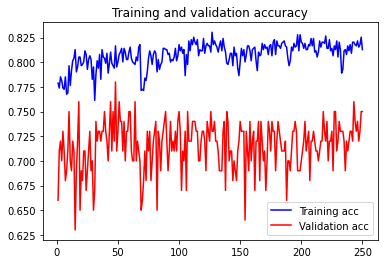

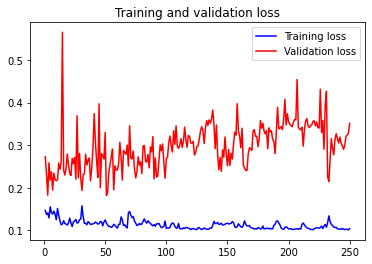

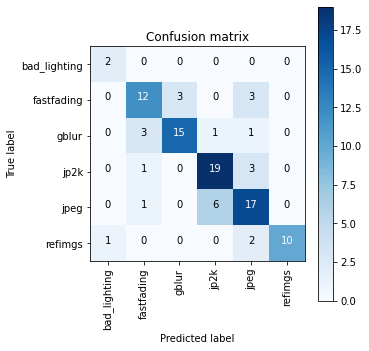

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("/content/drive/MyDrive/Datasets - Copy/trvlAcc1.png")
plt.show()

plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/Datasets - Copy/trvlLoss1.png")
plt.show()

import sklearn
import itertools
from sklearn.metrics import confusion_matrix
dict_characters = {0: 'Clear', 1: 'Blurry'}
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("/content/drive/MyDrive/Datasets - Copy/cm-"+title+".png")
    plt.show()

    
a=np.array(X_test)
b=np.array(y_test)
Y_pred = model.predict(a)


Y_pred_classes = np.argmax(Y_pred,axis=1)
confusion_mtx = confusion_matrix(np.argmax(b,axis=1), Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(image_classes))

In [ ]:
sklearn.metrics.accuracy_score(Y_pred_classes,np.argmax(b,axis=1))


0.75

In [ ]:
confusion_mtx


array([[ 2,  0,  0,  0,  0,  0],
       [ 0, 12,  3,  0,  3,  0],
       [ 0,  3, 15,  1,  1,  0],
       [ 0,  1,  0, 19,  3,  0],
       [ 0,  1,  0,  6, 17,  0],
       [ 1,  0,  0,  0,  2, 10]])

In [ ]:
accuracies = [class_correct_pred[i]/class_totals[i] for i in range(6)]
accuracies

[1.0, 0.3888888888888889, 0.7, 0.9130434782608695, 0.625, 0.7692307692307693]

In [ ]:
sumall = sum(map(sum, confusion_mtx))
print(sumall)
tn = [sumall - [sum(x) for x in zip(*confusion_mtx)][i] for i in range(6)]
tn
specificity = [tn[i]/(tn[i]+fp[i]) for i in range(6)]
specificity

100


[1.0, 0.9021739130434783, 0.9318181818181818, 0.8222222222222222, 1.0, 1.0]